In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import numpy as np

In [2]:
root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')

YEARS = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
images= "extracted-images"
metadata = "metadata_with_supertables_matching.dsv"
metadata_times = "metadata_matching_times.csv"

#### Combine meta data of all years

In [6]:
for i in range(len(YEARS)):
    metadf_ = pd.read_csv(root / str(YEARS[i]) / metadata, sep = '|')
    metadf_['year'] = [YEARS[i]]*len(metadf_) 
    if i > 0:
        metadf = pd.concat((metadf, metadf_), axis = 0)
    else:
        metadf = metadf_.copy()

print(metadf.shape)

(261428, 28)


In [7]:
metadf.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021])

#### Filter out accession numbers that are not matched to supertables. 

In [8]:
metadf.supertable_path.isna().sum()/len(metadf) # Just 0.2% of the images, so not worth spending time debugging

np.float64(0.0029338861942867635)

In [9]:
metadfsups = metadf.loc[metadf.supertable_path.notna()]

In [10]:
metadfsups.to_csv(root / 'metadata_with_supertables_filtered_matching.csv', index = False)

### Notes

In [11]:
metadf = pd.read_csv(root / 'metadata_with_supertables_filtered_matching.csv')

/tmp/ipykernel_3752361/2500053903.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  metadf = pd.read_csv(root / 'metadata_with_supertables_filtered_matching.csv')


In [12]:
notes_files = list(root.glob('IBJG_CXR_ACC_*'))

notes1 = pd.read_csv(notes_files[0], sep = '|')
notes2 = pd.read_csv(notes_files[1], sep = '|')
notes = pd.concat((notes1, notes2), axis = 0)

In [29]:
notes.to_csv(root / 'all_notes.csv')

In [13]:
metadf = metadf.loc[metadf.AccessionNumber.isin(notes.ACC_NBR)]

In [14]:
print(metadf.shape)

(260658, 28)


In [15]:
metadf.to_csv( root / 'metadata_with_supertables_filtered_notes_filtered_matching.csv', index = False)

### Match times

In [119]:
for i in range(len(YEARS)):
    try:
        metadf_times_ = pd.read_csv(root / str(YEARS[i]) / metadata_times)
    except FileNotFoundError:
        print(f"File not found for {YEARS[i]}")
        continue
    metadf_times_['year'] = [YEARS[i]]*len(metadf_times_) 
    if i > 0:
        metadf_times = pd.concat((metadf_times, metadf_times_), axis = 0)
    else:
        metadf_times = metadf_times_.copy()

print(metadf_times.shape)

(862397, 4)


In [120]:
metadf_times.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [121]:
metadf_times['StudyTimeRounded'] = metadf_times['StudyTime'].astype(int)

In [122]:
unique_metadf_times = metadf_times.drop_duplicates(subset = ['AccessionNumber', 'StudyTimeRounded'], keep='first')

In [123]:
unique_metadf_times.shape, metadf.shape

((337049, 5), (260658, 28))

In [124]:
metadf_merged_times = pd.merge(metadf, unique_metadf_times, on='AccessionNumber', how='left')

In [125]:
metadf_merged_times = metadf_merged_times.rename(columns = {'year_x': 'year'}).drop(columns = ['year_y', 'PatientID.1'])

In [127]:
metadf_merged_times.to_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times.csv', index = False)

### Find all rows with the correctly windowed cxr 
#### (lowest series number has the correct window- no idea why)

In [128]:
min_series_num = metadf_merged_times.groupby('AccessionNumber')['SeriesNumber'].min()

In [129]:
metadf_merged_times['SeriesSelector'] = metadf_merged_times.apply(lambda x: x['SeriesNumber'] if x['SeriesNumber'] == min_series_num[x.AccessionNumber] else 0, axis=1)

In [130]:
metadf_merged_times.to_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series.csv', index = False)

### Create Img Paths

In [136]:
import src.utils as utils
image_dir = "extracted-images"

In [137]:
metadf_merged_times['img_paths'] = metadf_merged_times.apply(lambda x: utils.acc_to_path(root,x['year'], image_dir, x['AccessionNumber'], x['SeriesNumber']), axis = 1)

In [138]:
metadf_merged_times.to_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths.csv', index = False)

### Match images to Supertables

In [3]:
metadf_merged_times = pd.read_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths.csv')

/tmp/ipykernel_2804052/3894577573.py:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  metadf_merged_times = pd.read_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths.csv')


##### Sanity Check

In [184]:
selected = metadf_merged_times.iloc[:10]

In [149]:
from PIL import Image
import matplotlib.pyplot as plt

1 63015.529


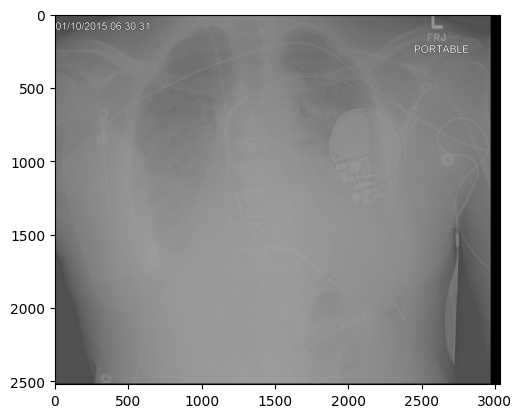

1001 115602.0


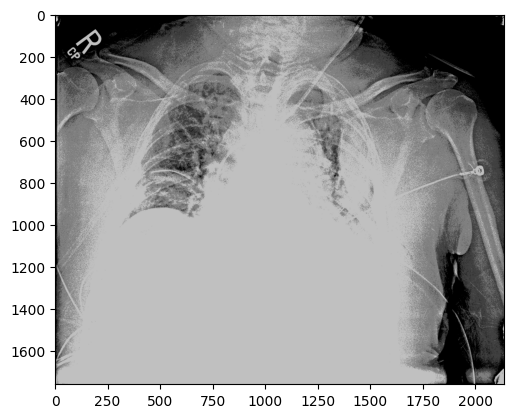

0 81015.932


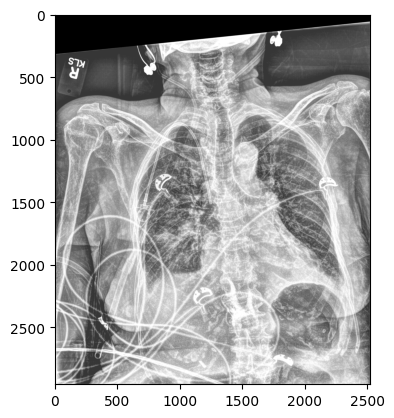

1001 75608.0


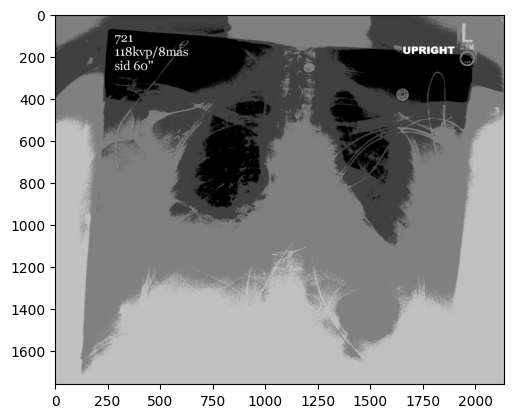

0 165139.046


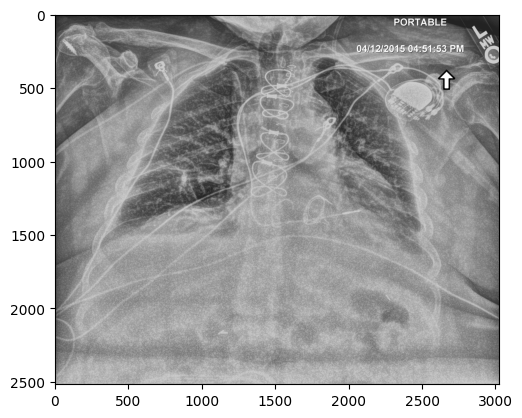

1 61901.713


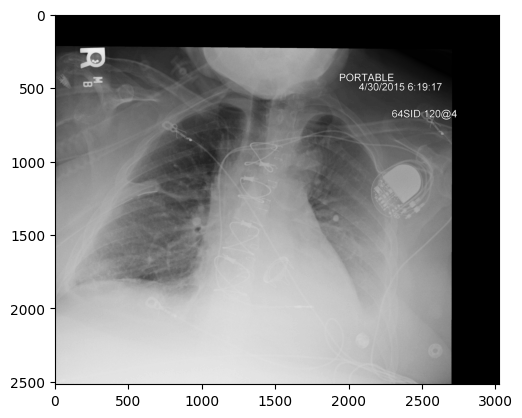

0 23334.9


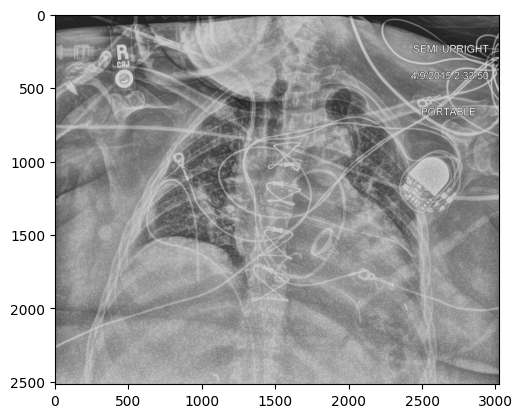

1 23334.9


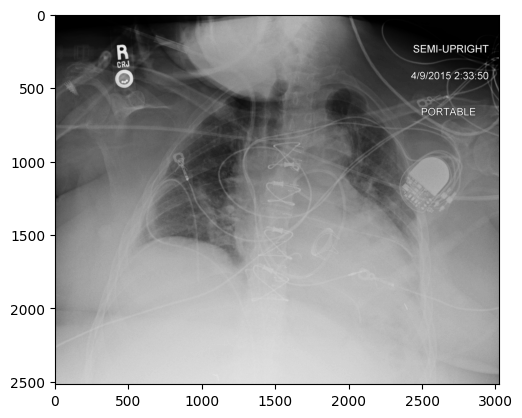

1 112101.859


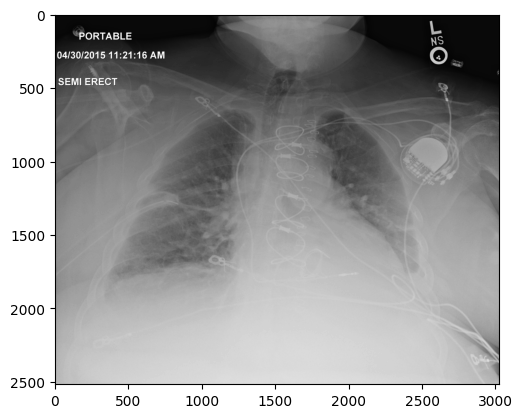

0 61901.713


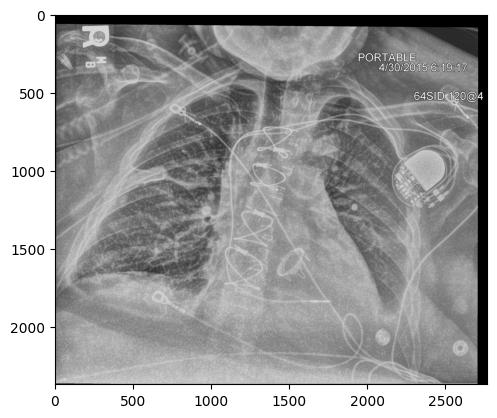

In [151]:
images= []
for i in range(len(selected)):
    img = Image.open(selected.iloc[i]['img_paths'])
    print(selected.iloc[i]['SeriesSelector'], selected.iloc[i]['StudyTime'])
    plt.imshow(img, cmap = 'grey')
    plt.show()
    images.append(img)

##### Convert StudyDate + StudyTimeRounded to pd.datetime

In [5]:
metadf = metadf_merged_times.copy()

In [16]:
metadf['StudyTimeProcessed'] = metadf.StudyTime.astype('str').apply(lambda x: x.split('.')[0][:-4] + ':' + x.split('.')[0][-4:-2] + ':' + x.split('.')[0][-2:])

In [17]:
metadf['StudyDateTime'] = metadf.apply(lambda x: x['StudyDate'] + ' ' + x['StudyTimeProcessed'], axis = 1)

In [18]:
metadf['StudyDateTimeProcessed'] = pd.to_datetime(metadf.StudyDateTime ,format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [19]:
metadf.loc[metadf['StudyDateTimeProcessed'].isna()].shape[0]/len(metadf)

0.025450591856423135

In [197]:
metadf.to_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths_datetime.csv', index = False)

In [11]:
import hashlib

def hash_value(value, hash_key = '123'):
    return hashlib.sha256((str(value) + hash_key).encode()).hexdigest()

In [32]:
metadf['supertable_path_hashed'] = metadf.supertable_path.apply(lambda x: root / 'matched_supertables_with_images' / (hash_value(str(Path(x).stem)) + '.pickle'))
metadf['supertable_path_hashed'] = metadf['supertable_path_hashed'].apply(lambda x: x if os.path.exists(x) else None)

metadf.to_csv(root / 'metadata_with_supertables_filtered_notes_filtered_matching_times_min_series_img_paths_datetime_hashed.csv', index=False)

#### Add to supertable (done in data/cxr_ehr_match.py) This is just a scratch space

#### Figuring out why some encounter dates don't match image dates

In [87]:
error_enc = np.load('slurmjobs/timing_mismatch_encounters.npy')

In [88]:
len(error_enc)

496

In [103]:
df = metadf.loc[metadf.ENCOUNTER_NBR == error_enc[300]]

In [104]:
df

,EMPI_NBR,ENCOUNTER_NBR,BED_LOCATION_START,BED_LOCATION_END,StudyDate,PatientID,StudyDescription,SeriesNumber,SeriesDescription,file,...,year,SeriesTime,StudyTime,StudyTimeRounded,SeriesSelector,img_paths,StudyTimeProcessed,StudyDateTime,StudyDateTimeProcessed,supertable_path_hashed
168886,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-14,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,34342.833672,34228.000000,34228,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,3:42:28,2021-04-14 3:42:28,2021-04-14 03:42:28,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168887,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-14,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,3,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,154756.902596,154752.501813,154752,0,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,15:47:52,2021-04-14 15:47:52,2021-04-14 15:47:52,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168888,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-15,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,42228.797367,42209.000000,42209,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,4:22:09,2021-04-15 4:22:09,2021-04-15 04:22:09,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168889,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-14,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,34342.833672,34228.000000,34228,0,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,3:42:28,2021-04-14 3:42:28,2021-04-14 03:42:28,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168890,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-15,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,42228.797367,42209.000000,42209,0,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,4:22:09,2021-04-15 4:22:09,2021-04-15 04:22:09,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168891,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-15,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,152724.953594,152719.709747,152719,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,15:27:19,2021-04-15 15:27:19,2021-04-15 15:27:19,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168892,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-14,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,154756.902596,154752.501813,154752,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,15:47:52,2021-04-14 15:47:52,2021-04-14 15:47:52,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
168893,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,1a74ce260407141e69e06d2d80c2074e51f2e87ae48d2b...,2021-04-13 15:00:39,2021-04-15 11:40:00,2021-04-15,7c9ea70b593a628b5341d77695f504e27ea8e682b3e7e0...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,152724.953594,152719.709747,152719,0,/hpc/group/kamaleswar

In [105]:
supertable_path = metadf.loc[metadf.ENCOUNTER_NBR == error_enc[300]]['supertable_path_hashed'].values[0]
supertable = pd.read_pickle(supertable_path)
supertable

,temperature,daily_weight_kg,height_cm,sbp_line,dbp_line,map_line,sbp_cuff,dbp_cuff,map_cuff,pulse,...,Albumin 5%,Albumin 5%_dose,infection,sepsis,CXR_ACC_NUM_1,CXR_ACC_NUM_2,CXR_ACC_NUM_3,CXR_ACC_NUM_4,CXR_ACC_NUM_5,Oxygen_Flow_Rate
2021-04-13 15:24:00,NaN,82.0,168.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 16:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 18:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 19:24:00,37.0,NaN,NaN,NaN,NaN,NaN,111.000000,79.0,90.000000,91.000000,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 20:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 21:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 22:24:00,36.3,NaN,NaN,NaN,NaN,NaN,126.000000,79.0,94.000000,93.000000,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 23:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-14 00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,0,0,00002DX210082424,00002DX210083351,00002DX210083351,00002DX210083351,00002DX210083351,NaN


In [111]:
 img_time - supertable.index[-1] < pd.Timedelta('1 days')

True

In [108]:
row = df.iloc[-1]
img_time = row['StudyDateTimeProcessed']
img_time


Timestamp('2021-04-15 15:27:19')

In [82]:
(pd.to_datetime(supertable.index[0]) - img_time)

Timedelta('-30 days +08:05:07')

In [59]:
files = list((root / 'matched_supertables_with_images').glob('*_timing.pickle'))

In [61]:
supertable = pd.read_pickle(files[0])

In [71]:
supertable.loc[supertable.cxr_timing.notna()][['cxr_timing', 'cxr_timing_approx_flag']].values

array([['152234d1d83ef6c42aee89eab06f5d990cf33363df629b7757d8d6ef657bc6f4_1',
        False],
       ['07301e610d597c09a817a34ed04be59cf61fc7d6767ae172c364ef85bd275f42_1',
        False]], dtype=object)

In [70]:
metadf.loc[metadf.ENCOUNTER_NBR == files[0].stem.split('_')[0]]

,EMPI_NBR,ENCOUNTER_NBR,BED_LOCATION_START,BED_LOCATION_END,StudyDate,PatientID,StudyDescription,SeriesNumber,SeriesDescription,file,...,year,SeriesTime,StudyTime,StudyTimeRounded,SeriesSelector,img_paths,StudyTimeProcessed,StudyDateTime,StudyDateTimeProcessed,supertable_path_hashed
259325,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,efd63a84027bfb47522d60bc0072533450566c5edbe35a...,2021-02-19 22:28:58,2021-02-22 23:16:04,2021-02-22,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,201244.206759,201234.000000,201234,0,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,20:12:34,2021-02-22 20:12:34,2021-02-22 20:12:34,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
259326,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,efd63a84027bfb47522d60bc0072533450566c5edbe35a...,2021-02-22 23:16:04,2021-02-23 21:14:42,2021-02-23,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,50253.348012,50248.392135,50248,0,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,5:02:48,2021-02-23 5:02:48,2021-02-23 05:02:48,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
259327,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,efd63a84027bfb47522d60bc0072533450566c5edbe35a...,2021-02-22 23:16:04,2021-02-23 21:14:42,2021-02-23,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,50253.348012,50248.392135,50248,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,5:02:48,2021-02-23 5:02:48,2021-02-23 05:02:48,/hpc/group/kamaleswaranlab/EmoryDataset/Images...
259349,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,efd63a84027bfb47522d60bc0072533450566c5edbe35a...,2021-02-19 22:28:58,2021-02-22 23:16:04,2021-02-22,48d7459a8fcca97bb2c2b1d84cbce142e56699288ca3fa...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,2021,201244.206759,201234.000000,201234,1,/hpc/group/kamaleswaranlab/EmoryDataset/Images...,20:12:34,2021-02-22 20:12:34,2021-02-22 20:12:34,/hpc/group/kamaleswaranlab/EmoryDataset/Images...


2 454.0


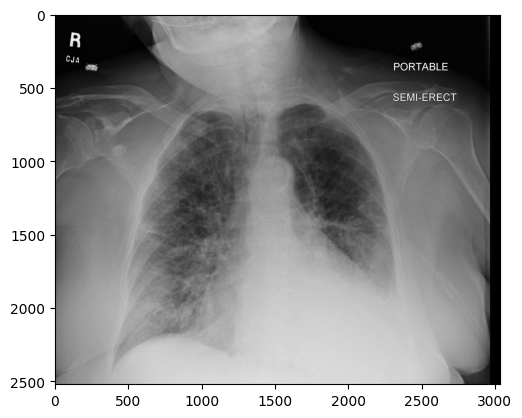

In [238]:
for i in range(len(encounter_cxrs)):
    img = Image.open(encounter_cxrs.iloc[i]['img_paths'])
    print(encounter_cxrs.iloc[i]['SeriesSelector'], encounter_cxrs.iloc[i]['StudyTime'])
    plt.imshow(img, cmap = 'grey')
    plt.show()
    images.append(img)